In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

# we load the FashionMNIST dataset
training_data = datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor()
)

test_data = datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor()
)

def img2vec(img):
    return torch.flatten(img, start_dim=2)

def vec2img(vec):
    return torch.unflatten(vec, -1, (48, 48))

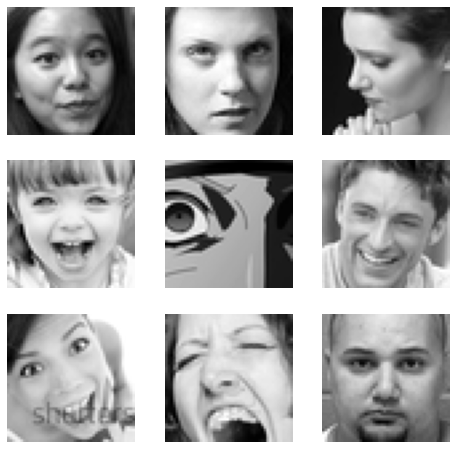

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Define model

In [3]:
from torch.nn import Module, Linear, Conv2d, ConvTranspose2d

class Encoder(Module):
    def __init__(self, c1, c2, lat):
        super(Encoder, self).__init__()
        self.conv1 = Conv2d(1, c1, 4)
        self.conv2 = Conv2d(c1, c2, 4)
        self.mean = Linear(c2 * 42 * 42, lat)
        self.std = Linear(c2 * 42 * 42, lat)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)

        mu = self.mean(x)
        sigma = torch.exp(self.std(x))

        return mu, sigma

class Decoder(Module):
    def __init__(self, c2, c1, lat):
        super(Decoder, self).__init__()
        self.c2 = c2
        self.l1 = Linear(lat, c2 * 42 * 42)
        self.conv1 = ConvTranspose2d(c2, c1, 4)
        self.conv2 = ConvTranspose2d(c1, 1, 4)

    def forward(self, z):
        z = torch.relu(self.l1(z))
        z = torch.unflatten(z, 1, (self.c2, 42, 42))
        z = torch.relu(self.conv1(z))
        z = torch.sigmoid(self.conv2(z))
        return z

class VAE(Module):
    def __init__(self, c1, c2, lat):
        super(VAE, self).__init__()
        self.encoder = Encoder(c1, c2, lat)
        self.decoder = Decoder(c2, c1, lat)
        self.img_loss = torch.tensor(0)

    def reconstruct_loss(self, x, y):
        #return torch.mean((x - y) ** 2) # for the continuous gaussian density
        return -torch.sum(x * torch.log(y + 1e-9) + (1 - x) * torch.log(1 - y + 1e-9))
    
    def kl_loss(self, mu, sigma):
        return torch.sum(mu ** 2 + sigma ** 2 - torch.log(sigma) - 0.5)
    
    def gaussian(self, mu, sigma):
        return mu + sigma * torch.normal(torch.zeros(mu.shape), torch.ones(mu.shape))
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.gaussian(mu, sigma)
        y = self.decoder(z)

        self.img_loss = self.reconstruct_loss(x, y) + self.kl_loss(mu, sigma)

        return y
    
    def batch_loss(self):
        return torch.sum(self.img_loss)

    def backward(self):
        self.img_loss.backward()

Define training loop

In [4]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

c1 = 4
c2 = 32
lat = 128
epochs = 5
batch_size = 128

training_data = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

batches = len(training_data)

vae = VAE(c1, c2, lat)
adam = Adam(vae.parameters())

for e in range(epochs):
    loss = 0
    for x_batch, _ in tqdm(training_data):
        adam.zero_grad()
        vae.forward(x_batch)

        loss += vae.batch_loss()
        vae.backward()
        adam.step()

    print(f"Training loss [{e + 1}/{epochs}]: {loss / batches / batch_size:0.4f}")

100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


Training loss [1/5]: 1651.7885


100%|██████████| 225/225 [03:06<00:00,  1.21it/s]


Training loss [2/5]: 1544.7438


100%|██████████| 225/225 [02:54<00:00,  1.29it/s]


Training loss [3/5]: 1447.2369


100%|██████████| 225/225 [02:43<00:00,  1.37it/s]


Training loss [4/5]: 1431.9391


100%|██████████| 225/225 [03:07<00:00,  1.20it/s]

Training loss [5/5]: 1424.3363


In [5]:
total_loss = 0
batches = len(test_data)

for x_batch, _ in test_data:
    vae.forward(x_batch)

    total_loss += vae.batch_loss()

print(f"Test loss: {total_loss / batches / batch_size:0.4f}")

Test loss: 1421.9285


Evaluate on test set

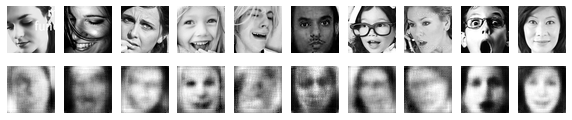

In [6]:
imgs = []
for test_batch, _ in test_data:
    for idx in range(batch_size):
        imgs.append(test_batch[idx])
        
        if len(imgs) == 10:
            break

    if len(imgs) == 10:
        break

cols, rows = 10, 2
figure = plt.figure(figsize=(cols, rows))
idx = 0
for i, img in zip(range(1, int(cols * rows / 2) + 1), imgs):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().squeeze(), cmap="gray")

    idx += 1

idx = 0
for i, img in zip(range(int(cols * rows / 2) + 1, cols * rows + 1), imgs):
    img = vae.forward(img[:, None, :, :])

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().squeeze(), cmap="gray")

    idx += 1

plt.show()

Sample from latent space distribution

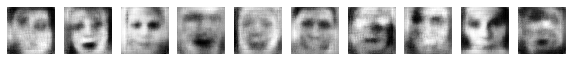

In [7]:
cols, rows = 10, 1
figure = plt.figure(figsize=(cols, rows))
for i in range(1, 10 + 1):
    img = vae.decoder(torch.normal(torch.zeros(lat), torch.ones(lat))[None, :])

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().squeeze(), cmap="gray")